# Example notebook
## Xiaonan Wang
## 10May2020

In [1]:
#%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import os
import smqpp
import re
import anndata

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)

/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.4.6 anndata==0.7.1 umap==0.4.1 numpy==1.18.2 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [2]:
# read in metadata
# This needs to be tidied up first
metadir = '/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Lab_Members/Niki/Patel_SMQ2/MetaData/'
meta_list = np.array(np.sort(os.listdir(metadir)))
meta_list = meta_list[meta_list!='meta_B2.csv']
print(meta_list)
meta = pd.DataFrame([])
for f in meta_list:
    meta_sub = pd.read_csv(metadir+f,  engine='python')
    meta_sub= meta_sub.dropna(axis=1, how='all')
    meta_sub = smqpp.reformat_meta(meta_sub)
    print(f+':'+str(meta_sub.shape))
    meta = meta.append(meta_sub, ignore_index=True)
    del meta_sub
meta.index=(meta['Sequencing_identifier'].astype(str)+'.'+[x.replace('-', '_') for x in meta['Sequencing_facility_index']]).values
print(meta.shape)

['meta_B1.csv' 'meta_B3.csv' 'meta_B4.csv']
meta_B1.csv:(768, 17)
meta_B3.csv:(768, 17)
meta_B4.csv:(1224, 17)
(2760, 17)


In [3]:
Indir = '/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Lab_Members/Niki/Patel_SMQ2/STAR_results/'
ftable_loc = '/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Lab_Members/Niki/Patel_SMQ2/Analysis/features.tsv'
folder_list = np.array(os.listdir(Indir))
# remove bulk samples
folder_list = np.sort(folder_list[(folder_list!='SLX14873') & (folder_list!='SLX16890')])
print(folder_list)

['SLX14256' 'SLX14257' 'SLX14719' 'SLX14789' 'SLX16885' 'SLX16886'
 'SLX16888' 'SLX16889']


In [4]:
# define QC thresholds
cutoff_B1=[0, np.log10(150000), 0.15, 0, 0.2, 0.2, float('nan'), float('nan'), float('nan'), float('nan')]
cutoff_B2=[0, np.log10(120000), 0.1, 0, 0.2, 0.25, float('nan'), float('nan'), float('nan'), float('nan')]
cutoff_B3=[0, np.log10(150000), 0.1, 0, 0.2, 0.28, float('nan'), float('nan'), float('nan'), float('nan')]
cutoff_B4=[0, np.log10(150000), 0.15, 0, 0.2, 0.2, float('nan'), float('nan'), float('nan'), float('nan')]
cutoff_B5=[0, np.log10(120000), 0.15, 0, 0.2, 0.2, float('nan'), float('nan'), float('nan'), float('nan')]
cutoff_B6=[0, np.log10(120000), 0.15, 0, 0.2, 0.2, float('nan'), float('nan'), float('nan'), float('nan')]
cutoff_B7=[0, np.log10(120000), 0.15, 0, 0.2, 0.2, float('nan'), float('nan'), float('nan'), float('nan')]
cutoff_B8=[0, np.log10(120000), 0.15, 0, 0.2, 0.2, float('nan'), float('nan'), float('nan'), float('nan')]
cutoff = [cutoff_B1, cutoff_B2, cutoff_B3, cutoff_B4, cutoff_B5, cutoff_B6, cutoff_B7, cutoff_B8]

SLX14256
Number of passed cells: 370
Number of failed cells: 14
SLX14257
Number of passed cells: 354
Number of failed cells: 30
SLX14719
Number of passed cells: 346
Number of failed cells: 38
SLX14789
Number of passed cells: 367
Number of failed cells: 17
SLX16885
Number of passed cells: 256
Number of failed cells: 32
SLX16886
Number of passed cells: 283
Number of failed cells: 5
SLX16888
Number of passed cells: 275
Number of failed cells: 13
SLX16889
Number of passed cells: 285
Number of failed cells: 3


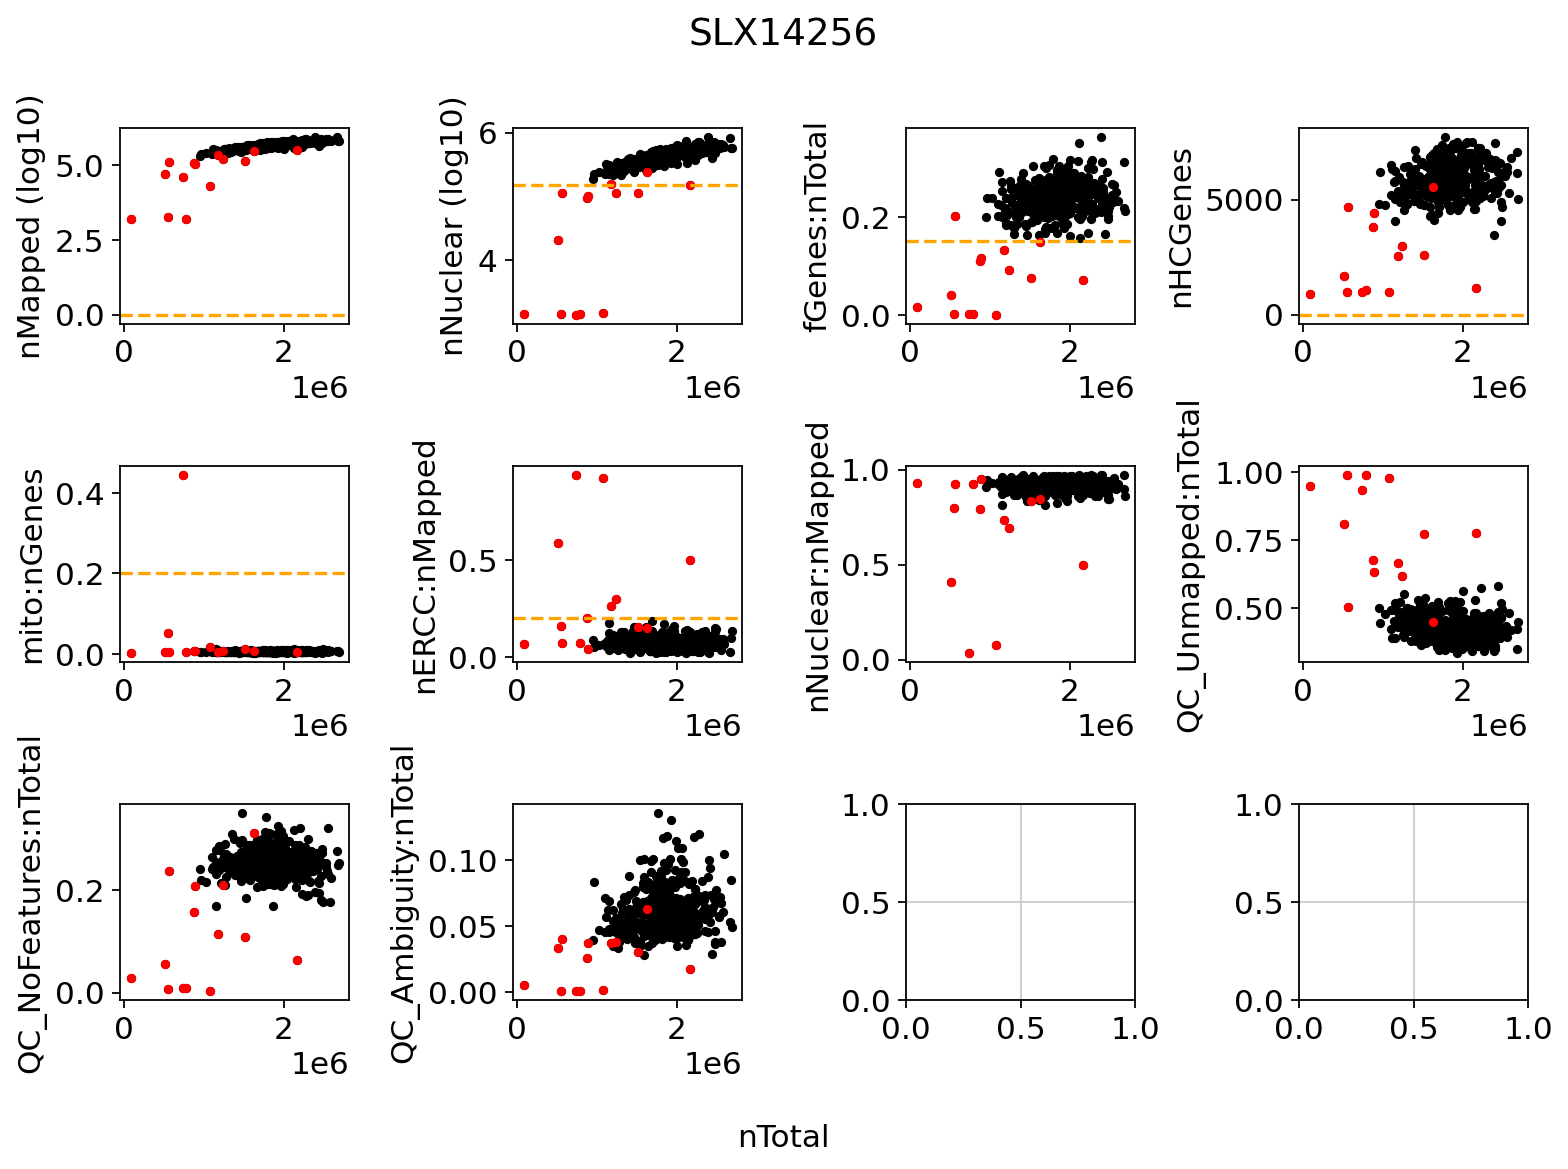

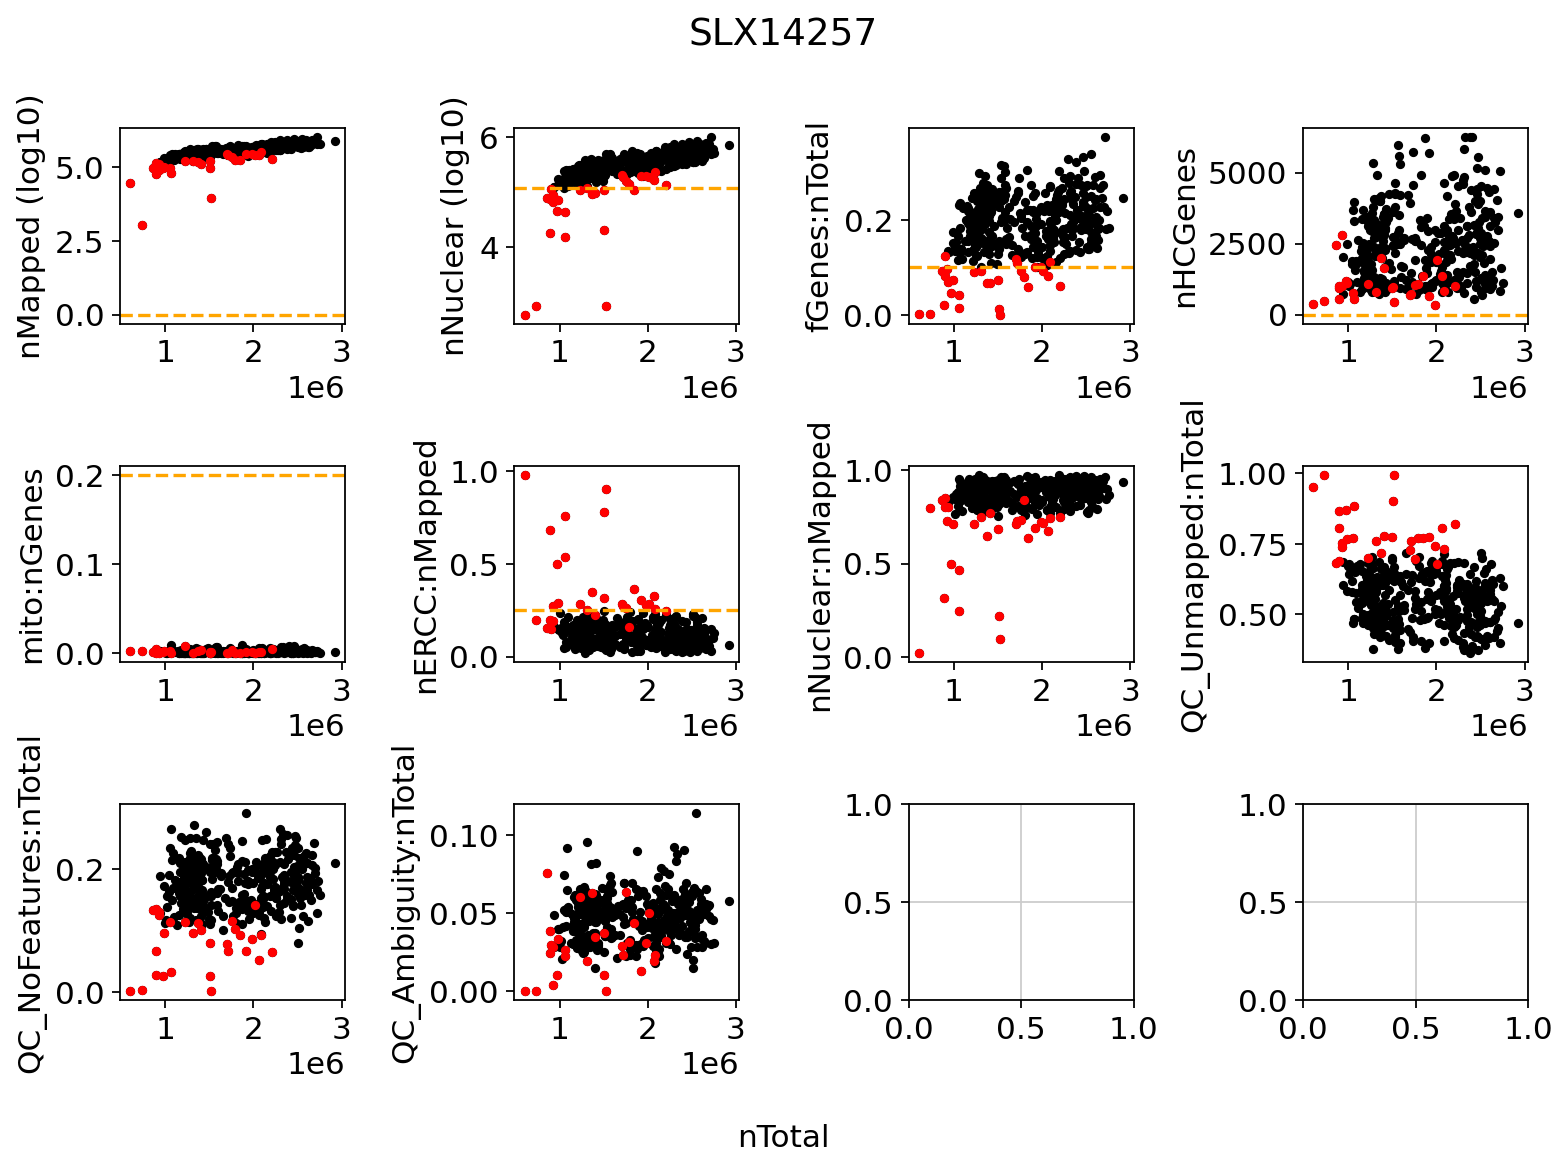

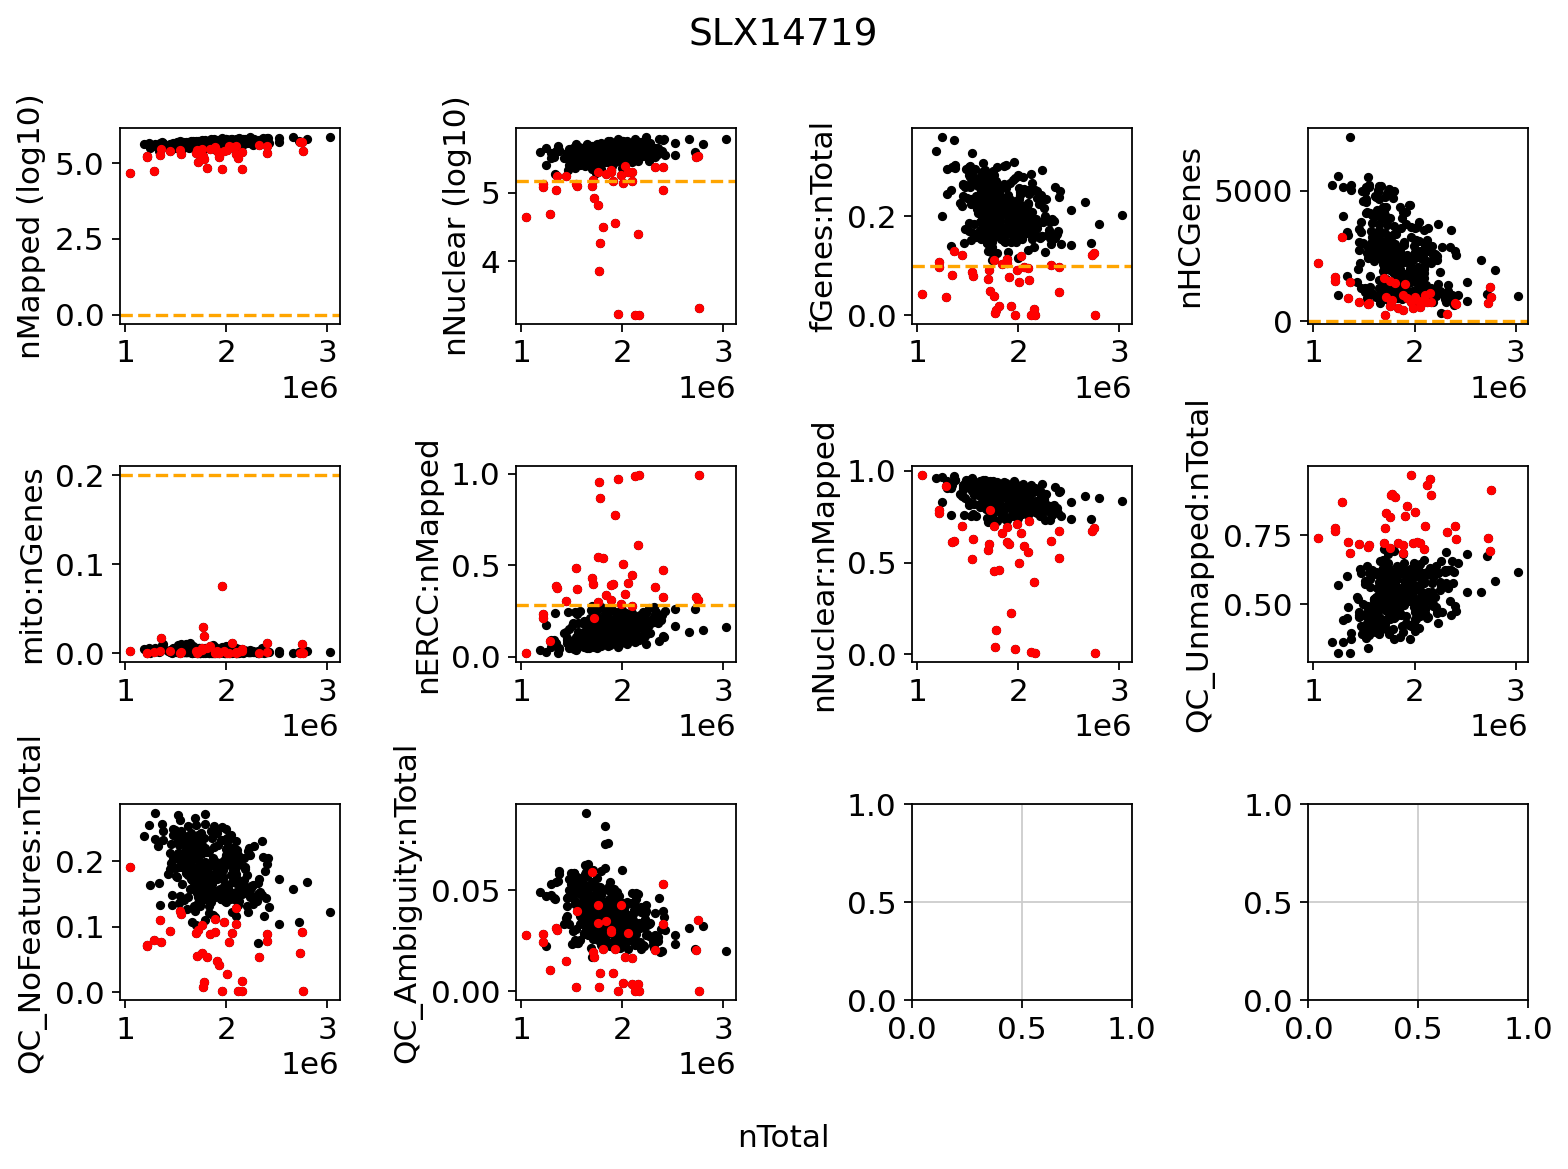

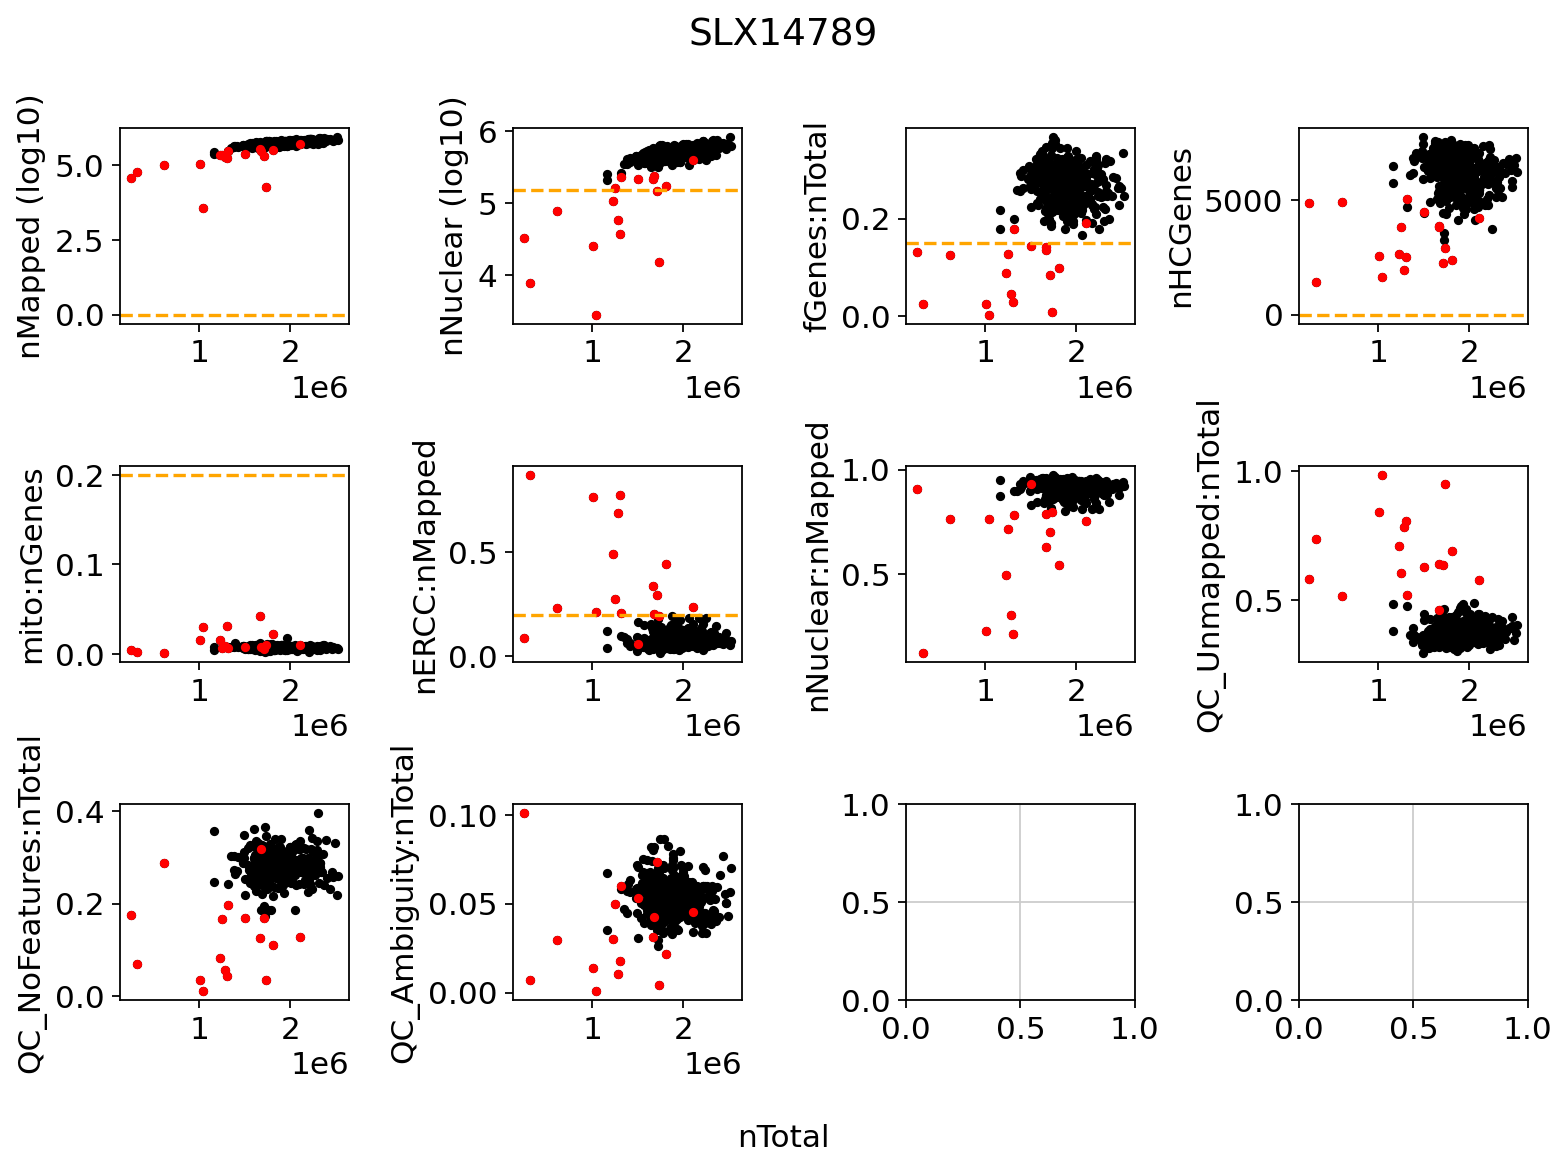

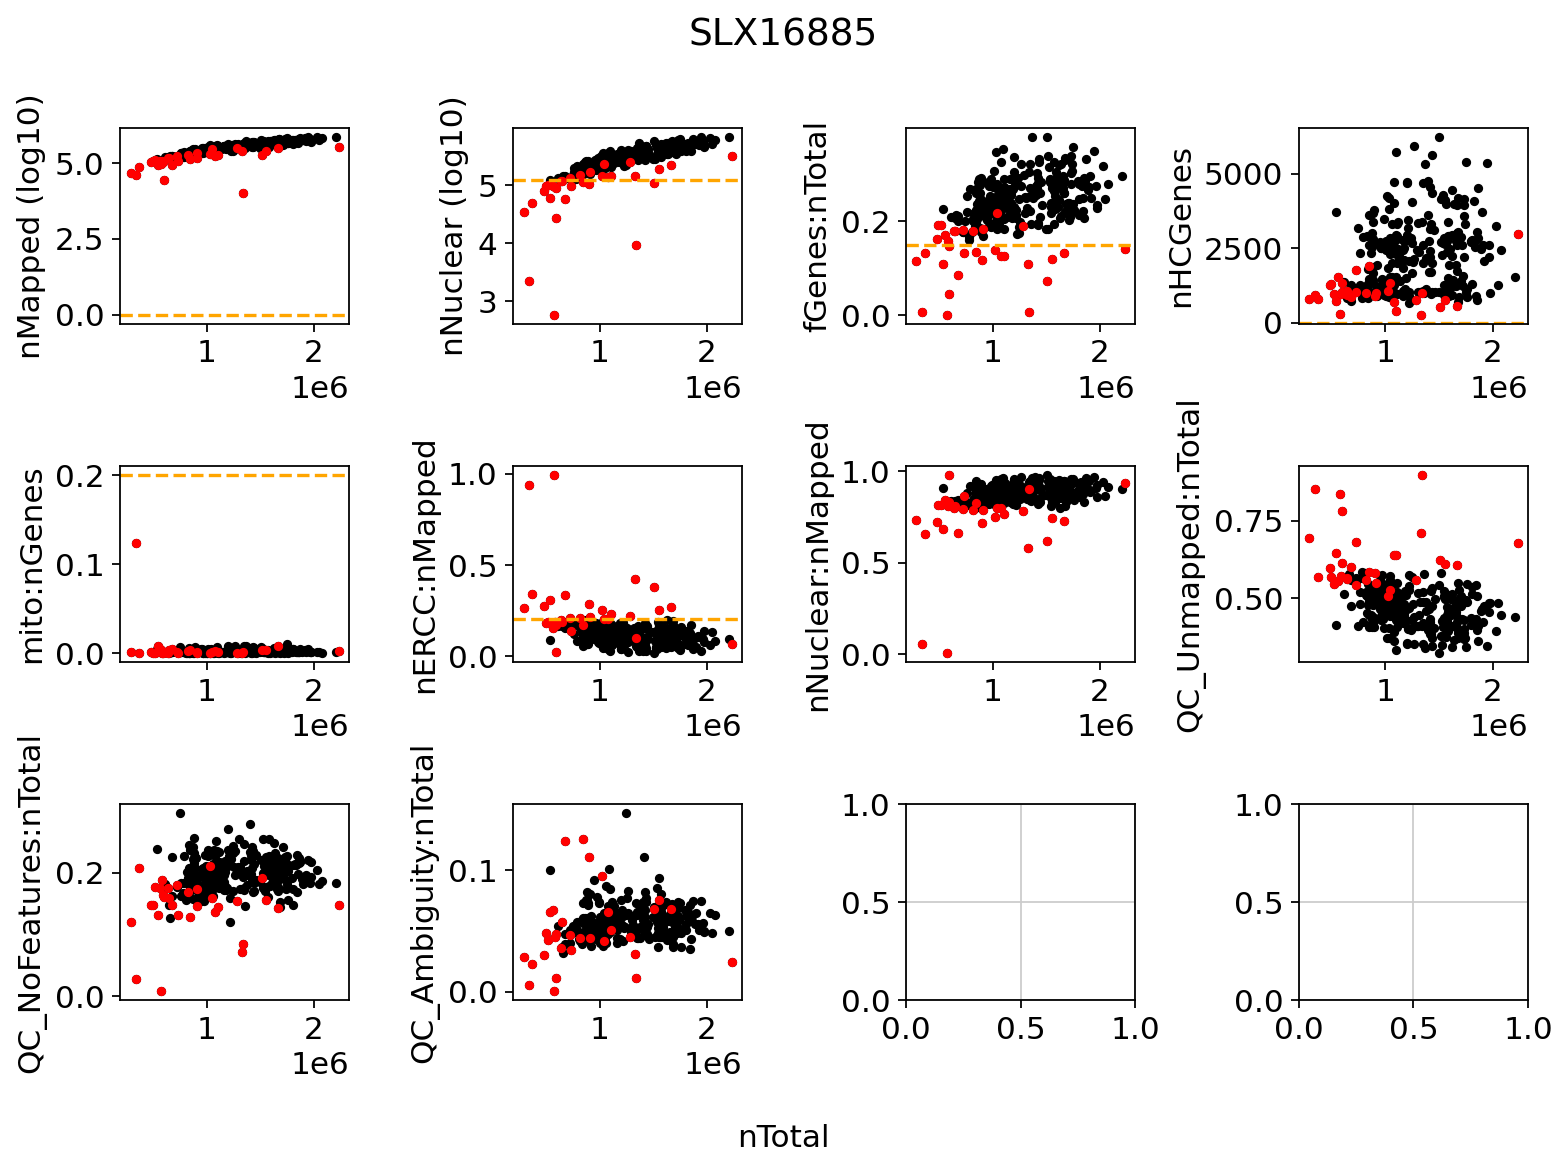

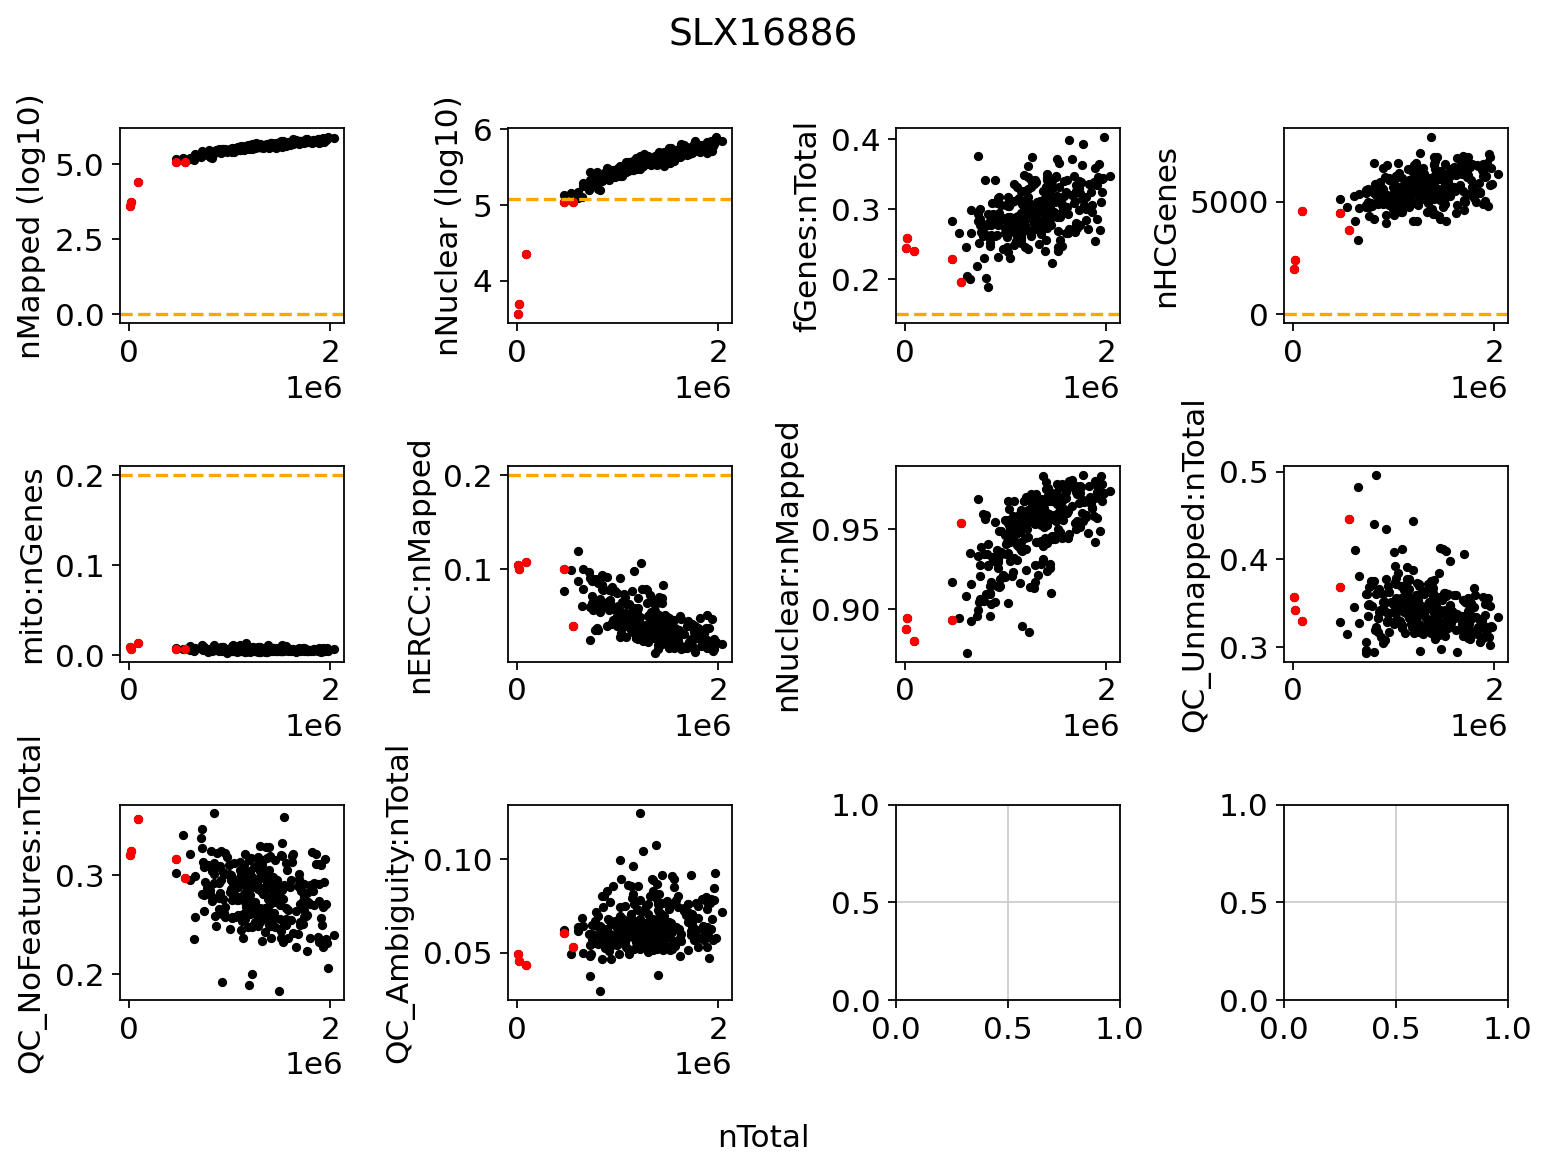

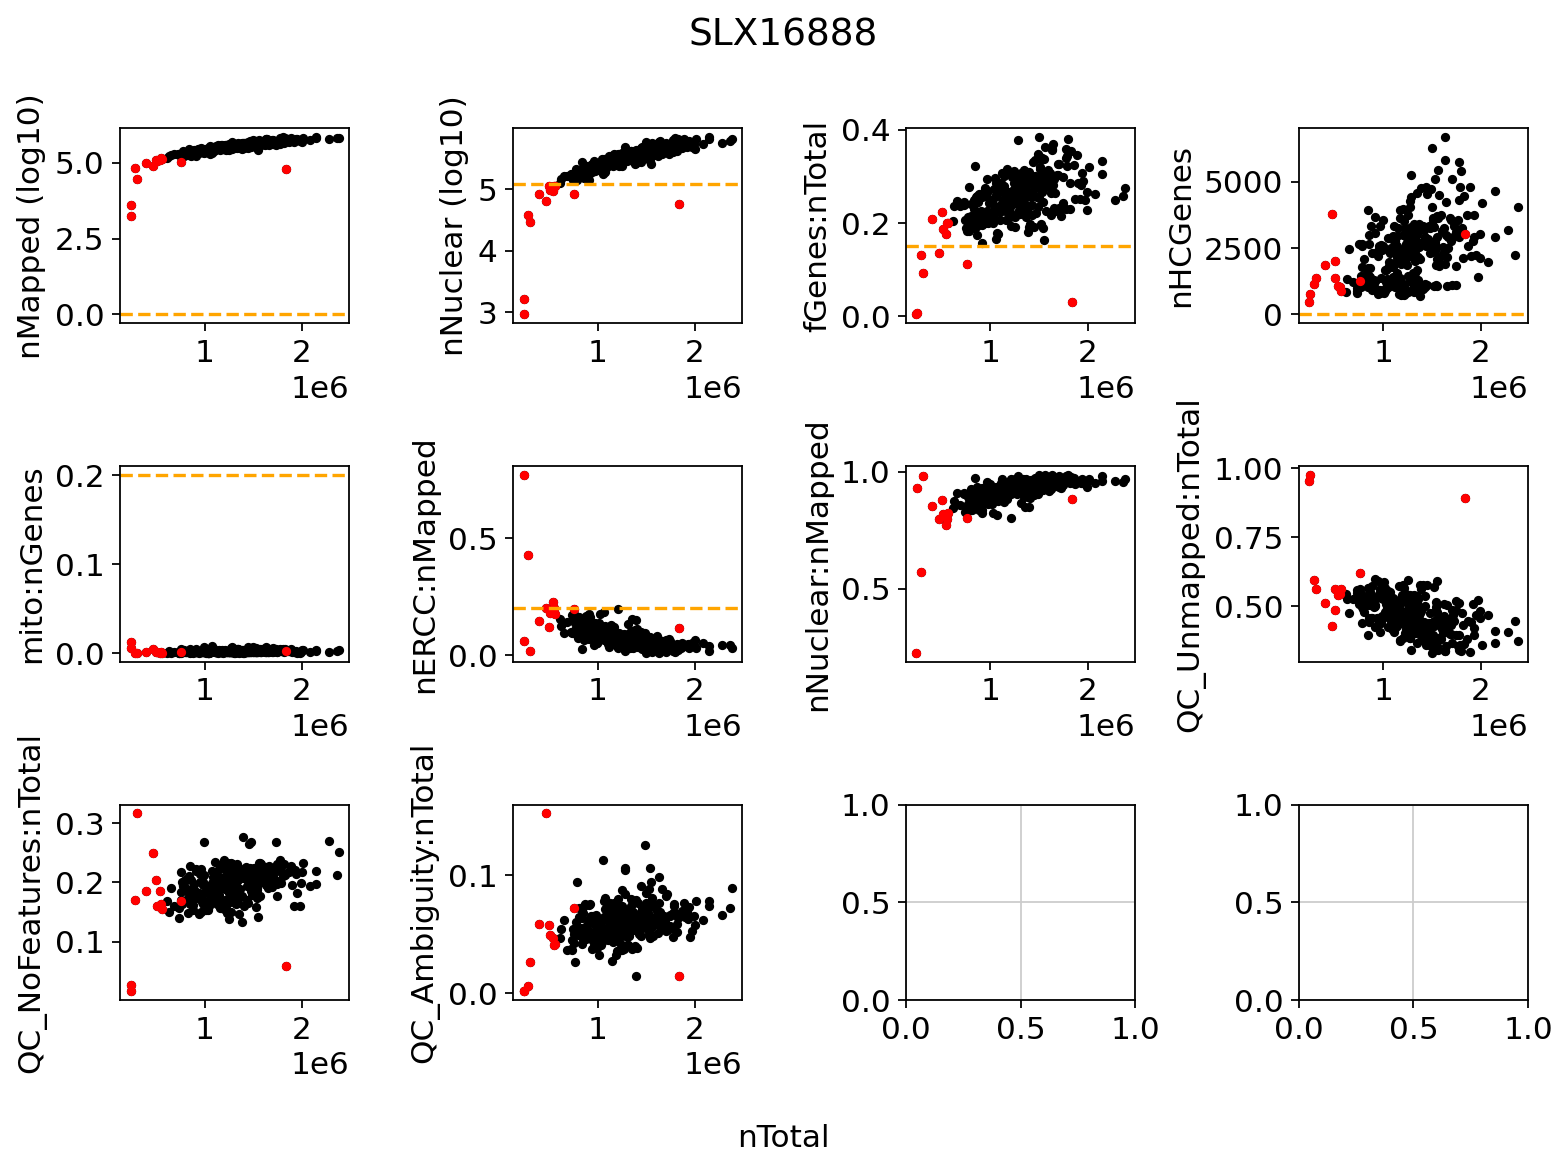

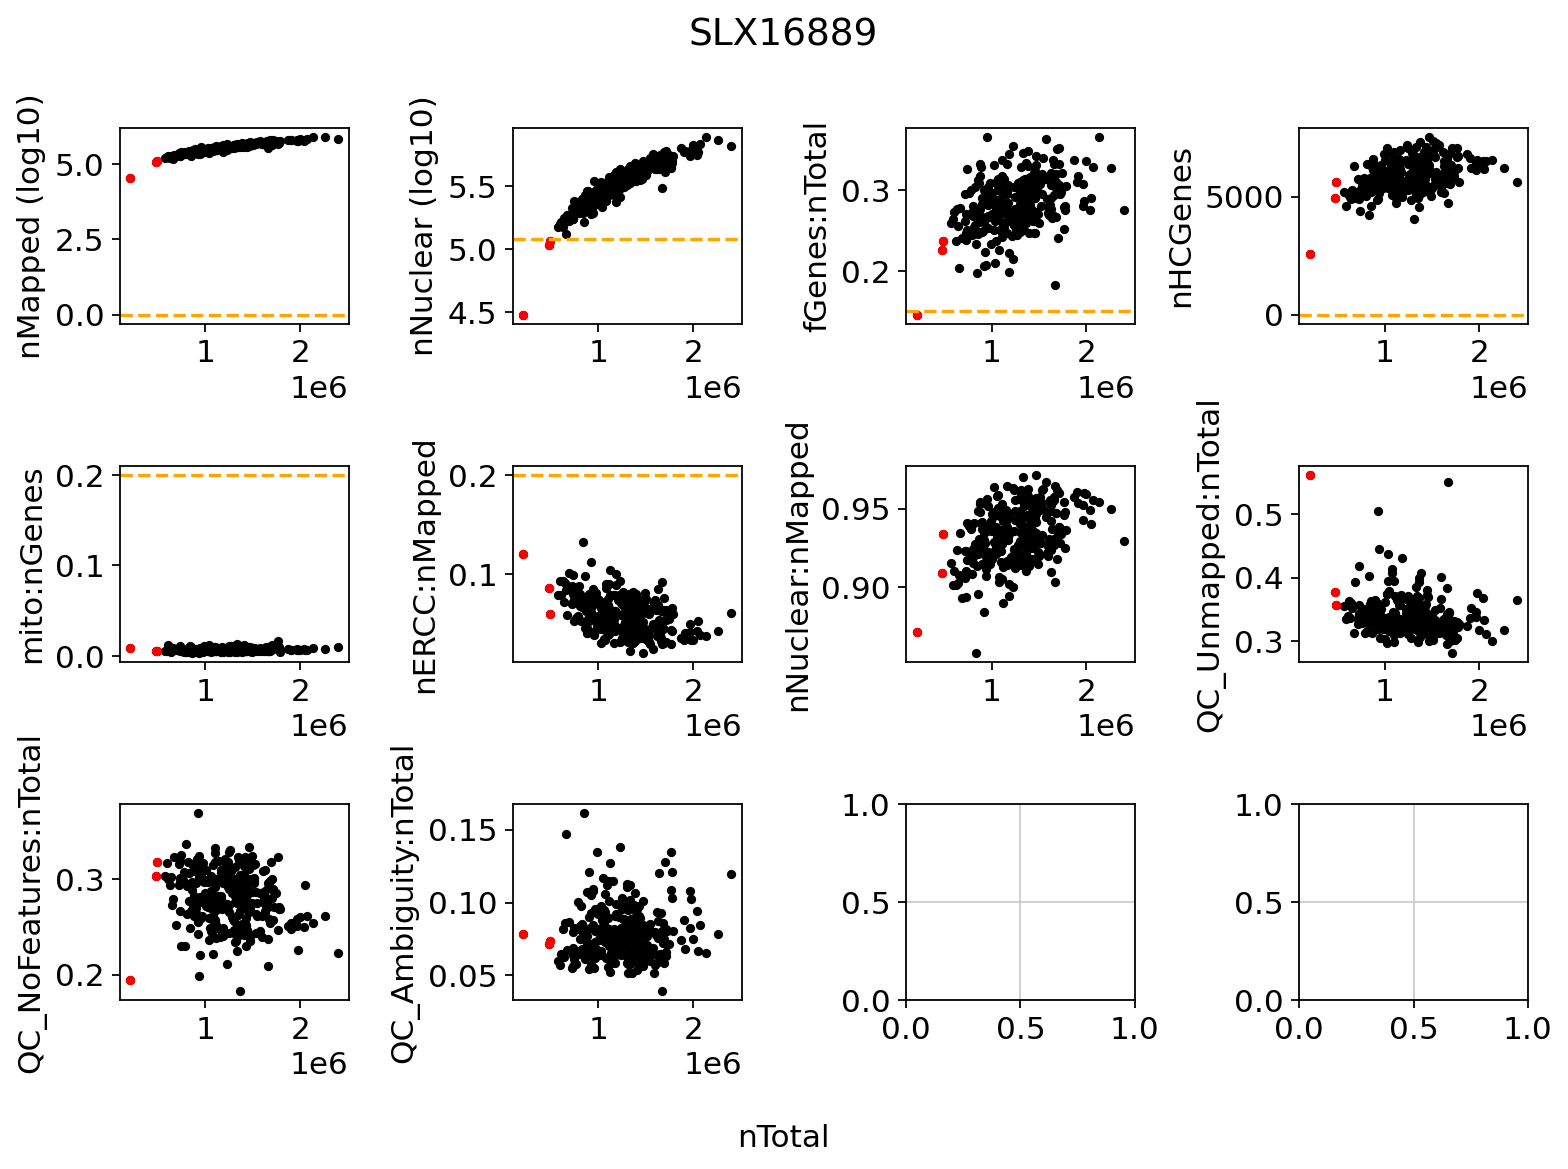

In [5]:
# Now do QC for each SLX batch
adata = []
for i in range(len(folder_list)):
    print(folder_list[i])
    adata_sub =  smqpp.read_in_files(Indir+folder_list[i], ftable_loc)
    adata_sub = smqpp.smartseq_qc(adata_sub,cutoff=cutoff[i], title=folder_list[i])
    adata.append(adata_sub)
    del adata_sub

In [8]:
# Combine data into a single object
adata = anndata.AnnData.concatenate(adata[0], adata[1], adata[2], adata[3], adata[4], adata[5], adata[6], adata[7])
sc.pp.filter_genes(adata, min_cells=1)

filtered out 6674 genes that are detected in less than 1 cells


In [9]:
# Normalization using DESeq2 method
smqpp.normalise_data(adata)

Calculate SF for genes:
Filtered matrix shape: (2536, 13)
Number of valid means:13
Calculate SF for erccs:
Filtered matrix shape: (2536, 15)
Number of valid means:15


In [10]:
# Select HVGs using Brennecke
smqpp.tech_var(adata, useERCC=True) 

MeanForFit:  17.59918241764378
32
Length of HVGs: 9717


/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/smqpp/__init__.py:316: RuntimeWarning: invalid value encountered in true_divide
  cv2s = (sStd/sMean)**2
/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/smqpp/__init__.py:321: RuntimeWarning: invalid value encountered in greater
  meanForFit = np.quantile(sMean[cv2s>cvThresh], quant)
/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:278: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  DomainWarning)


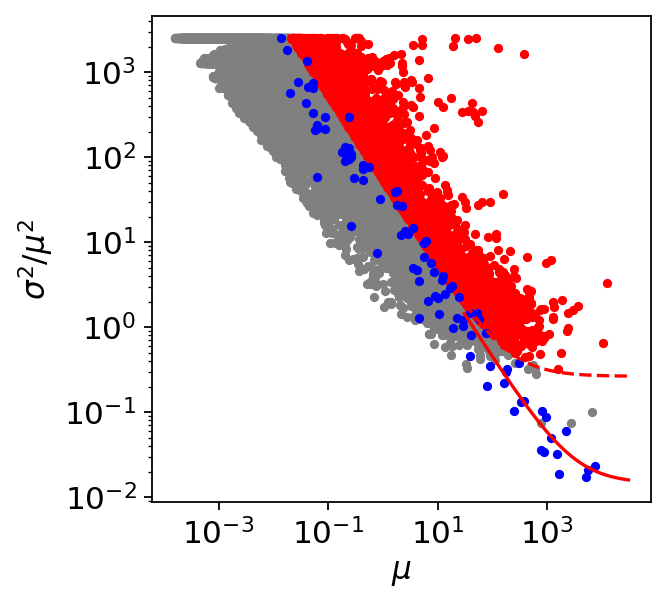

In [11]:
# plot out the HVG selection
smqpp.plot_tech_var(adata)